# How to Compare Two or More Distributions

*A complete guide to comparing distributions, from visualization to statistical tests*

Comparing the empirical distribution of a variable across different groups is a common problem in data science. In particular, in causal inference the problem often arises when we have to **assess the quality of randomization**. 

When we want to assess the causal effect of a policy (or UX feature, ad campaign, drug, ...), the golden standard in causal inference are [**randomized control trials**](https://en.wikipedia.org/wiki/Randomized_controlled_trial), also known as [**A/B tests**](https://de.wikipedia.org/wiki/A/B-Test). In practice, we select a sample for the study and we randomly split it into a **control** and a **treatment** group, and we compare the outcomes between the two groups. Randomization ensures that only difference between the two groups is the treatment, on average, so that we can attribute outcome differences to the treatment effect.

The **problem** is that, despite randomization, the two groups are never identical. However, sometimes, they are not even "similar". For example, we might have more males in one group, or older people, etc.. (we usually call these characteristics, *covariates* or *control variables*). When it happens, we cannot be certain anymore that the difference in the outcome is only due to the treatment and cannot be attributed to the **inbalanced covariates** instead. Therefore, it is always important, after randomization, to check whether all observed variables are balanced across groups and whether there are no systematic differences. Another option, to be certain ex-ante that certain covariates are balanced, is [stratified sampling](https://en.wikipedia.org/wiki/Stratified_sampling).

In this blog post, we are going to see different ways to compare two (or more) distributions and assess the magnitude and significance of their difference. We are going to consider two different approaches, **visual** and **statistical**. The two approaches generally trade-off **intuition** with **rigor**: from plots we can quickly assess and explore differences, but it's hard to tell whether these differences are systematic or due to noise.

## Example

Let's assume we need to perform an **experiment** on a group of individuals and we have randomized them into a **treatment and control** group. We would like them to be **as comparable as possible**, in order to attribute any difference between the two groups to the treatment effect alone. We also have divided the treatment group in different *arms* for testing different treatments (e.g. slight variations of the same drug).

For this example, I have simulated a dataset of 1000 individuals, for whom we observe a set of characteristics. I import the data generating process `dgp_rnd_assignment()` from [`src.dgp`](https://github.com/matteocourthoud/Blog-Posts/blob/main/notebooks/src/dgp.py) and some plotting functions and libraries from [`src.utils`](https://github.com/matteocourthoud/Blog-Posts/blob/main/notebooks/src/utils.py).

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from src.utils import *
from src.dgp import dgp_rnd_assignment

df = dgp_rnd_assignment().generate_data()
df.head()

,Group,Arm,Gender,Age,Income
0,control,NaN,0,29.0,568.44
1,control,NaN,1,32.0,596.45
2,treatment,arm 3,0,29.0,380.86
3,control,NaN,0,25.0,476.38
4,treatment,arm 4,1,32.0,628.28


We have information on $1000$ individuals, for which we observe `gender`, `age` and weekly `income`. Each individual is assigned either to the treatment or control `group` and treated individuals are distributed across four treatment `arms`.

## Two Groups - Plots

Let's start with the simplest setting: we want to compare the distribution of income across the `treatment` and `control` group. We first explore **visual** approaches and the **statistical** approaches. The advantage of the first is **intuition** while the advantage of the second is **rigor**.

For most visualizations I am going to use Python's [`seaborn`](https://seaborn.pydata.org/) library.

### Boxplot

A first visual approach is the [**boxplot**](https://en.wikipedia.org/wiki/Box_plot). The boxplot is a good trade-off between summary statistics and data visualization. The center of the **box** represents the *median* while the borders represent the first (Q1) and third [quartile](https://en.wikipedia.org/wiki/Quartile) (Q3), respectively. The **whiskers** instead, extend to the first data points that are more than 1.5 times the *interquartile range* (Q3 - Q1) outside the box. The points that fall outside of the whiskers are plotted individually and are usually considered [**outliers**](https://en.wikipedia.org/wiki/Outlier). 

Therefore, the boxplot provides both summary statistics (the box and the whiskers) and direct data visualization (the outliers).

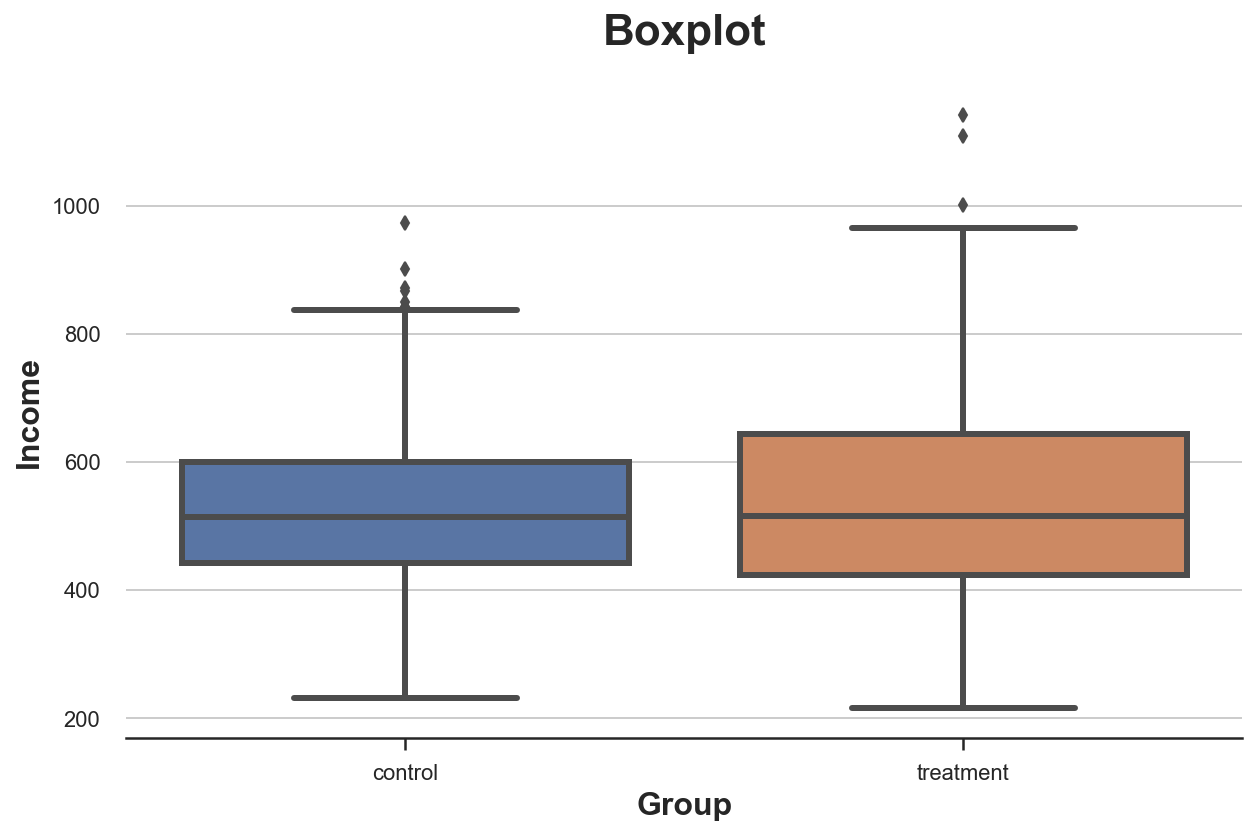

In [3]:
sns.boxplot(data=df, x='Group', y='Income');
plt.title("Boxplot");

It seems that the `income` distribution in the `treatment` group is slightly more dispersed: the orange box is larger and its whiskers cover a wider range. However, the **issue** with the boxplot is that it hides the shape of the data, telling us some summary statistics but not showing us the actual data distribution.

### Histogram

The most intuitive way to plot a distribution is the **histogram**. The histogram groups the data into equally wide **bins** and plots the number of observations within each bin.

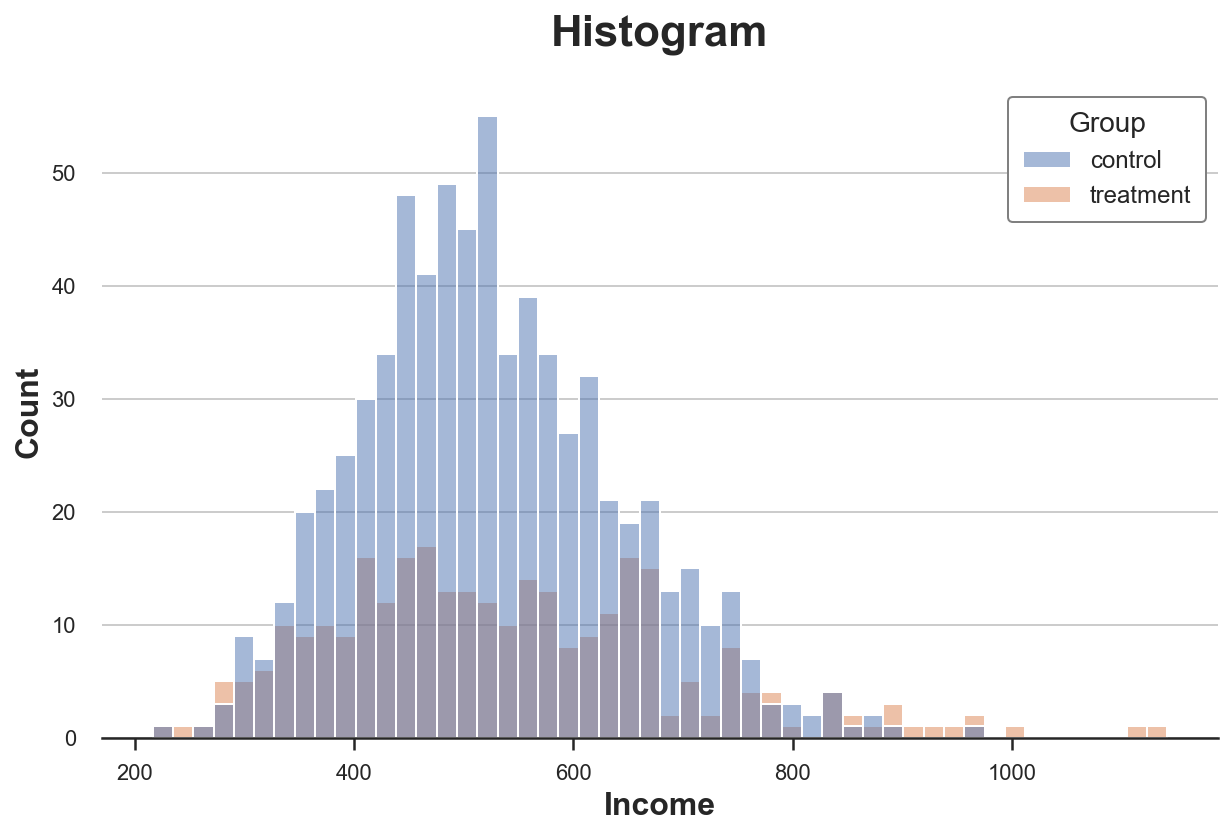

In [4]:
sns.histplot(data=df, x='Income', hue='Group', bins=50);
plt.title("Histogram");

There are multiple **issues** with this plot:

- Since the two groups have a different number of observations, the two histograms are not comparable
- The number of bins is arbitrary

We can solve the first issue using the `stat` option to plot the `density` instead of the count and setting the `common_norm` option to `False` to use the same normalization.

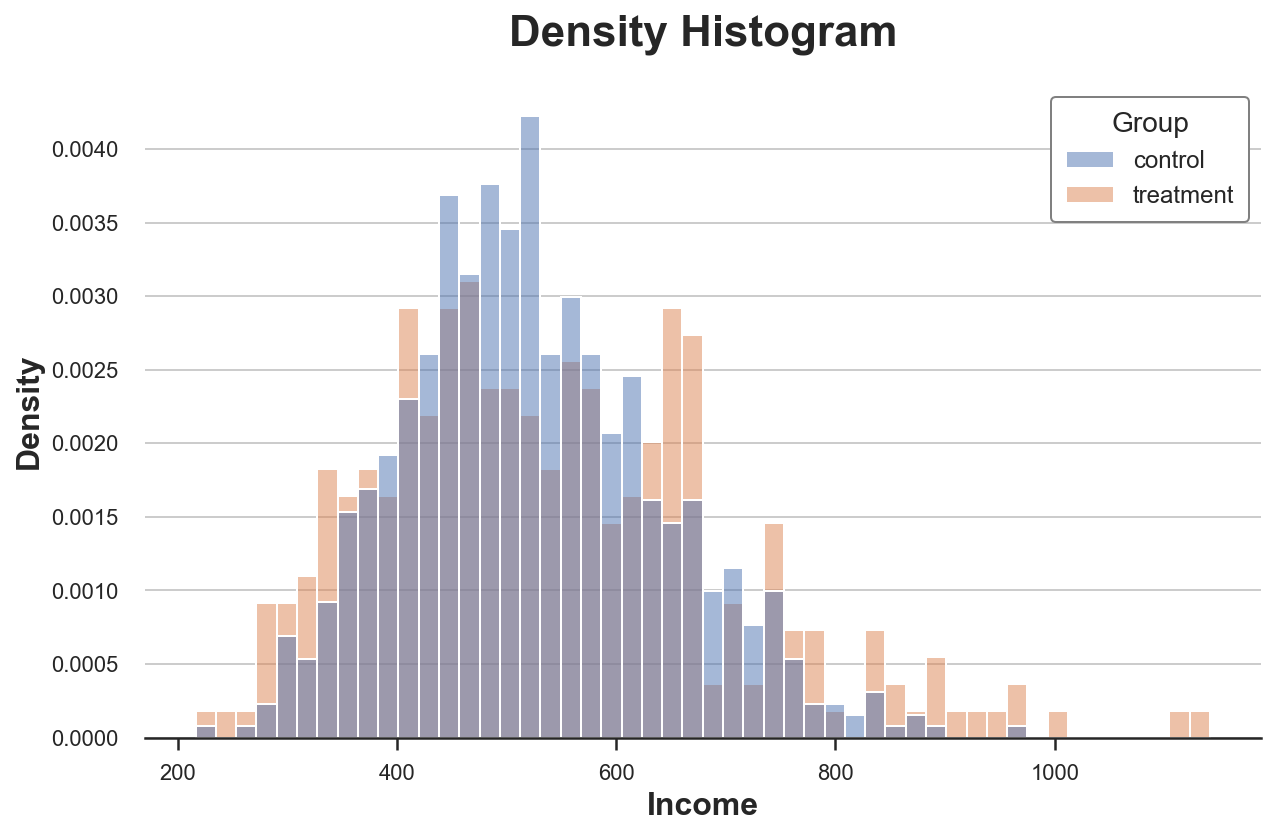

In [5]:
sns.histplot(data=df, x='Income', hue='Group', bins=50, stat='density', common_norm=False);
plt.title("Density Histogram");

Now the two histograms are comparable!

However, an important **issue** remains: the size of the bins is arbitrary. In the extreme, if we bunch the data less, we end up with bins with at most one observation, if we bunch the data more, we end up with a single bin. In both cases, if we exaggerate, the plot loses informativeness. This is a classical [bias-variance trade-off](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff).

### Kernel Density

One possible solution is to use a [**kernel density function**](https://en.wikipedia.org/wiki/Kernel_density_estimation) that tries to approximate the histogram with a continuous function, using [kernel density estimation (KDE)](https://en.wikipedia.org/wiki/Kernel_density_estimation).

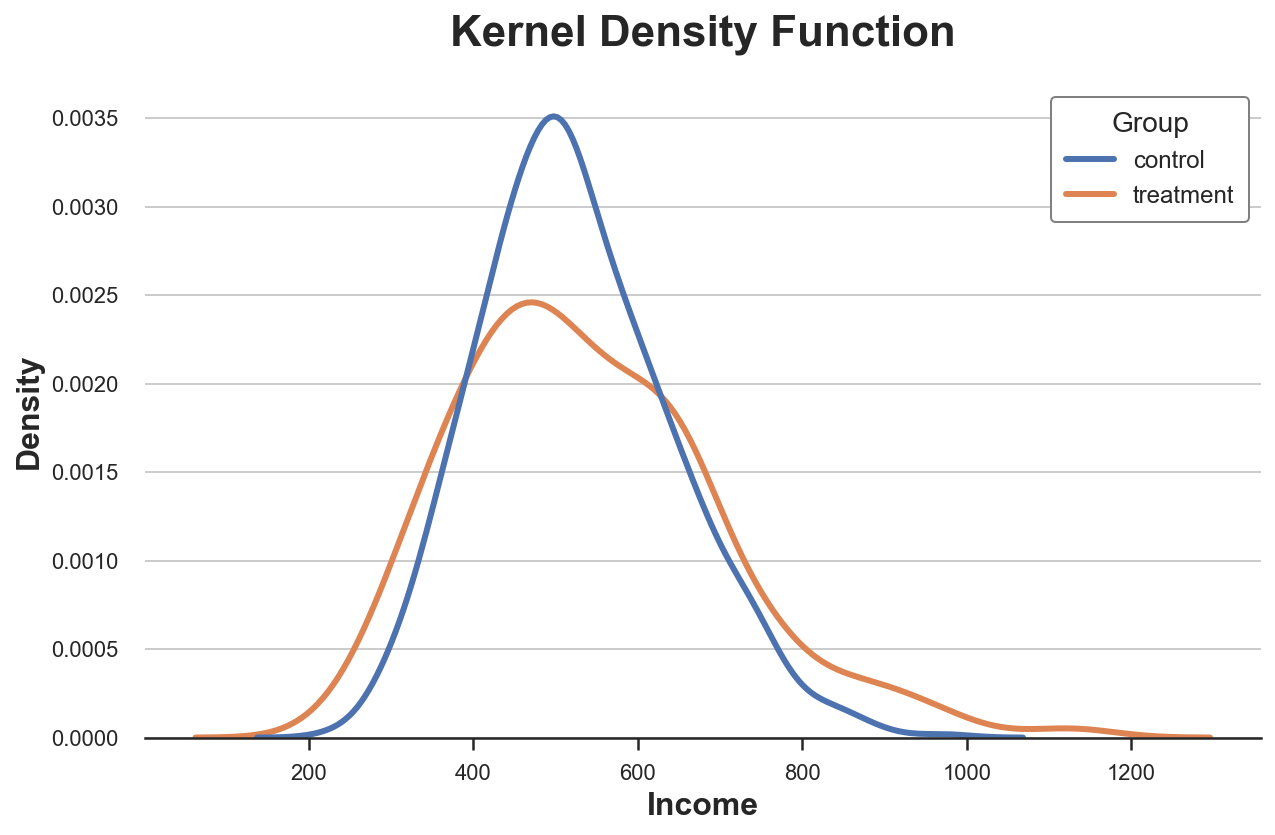

In [6]:
sns.kdeplot(x='Income', data=df, hue='Group', common_norm=False);
plt.title("Kernel Density Function");

From the plot, it seems that the estimated kernel density of `income` has "fatter tails" (i.e. higher variance) in the `treatment` group, while the average seems similar across groups.

The **issue** with kernel density estimation is that it is a bit of a  black-box and might mask relevant features of the data.

### Cumulative Distribution

A more transparent representation of the two distribution is their [**cumulative distribution function**](https://en.wikipedia.org/wiki/Cumulative_distribution_function). At each point of the x axis (`income`) we plot the percentage of data points that have an equal or lower value. The main **advantages** of the cumulative distribution function are that

- we do not need to make any arbitrary choice (e.g. number of bins)
- we do not need to perform any approximation (e.g. with KDE), but we represent all data points

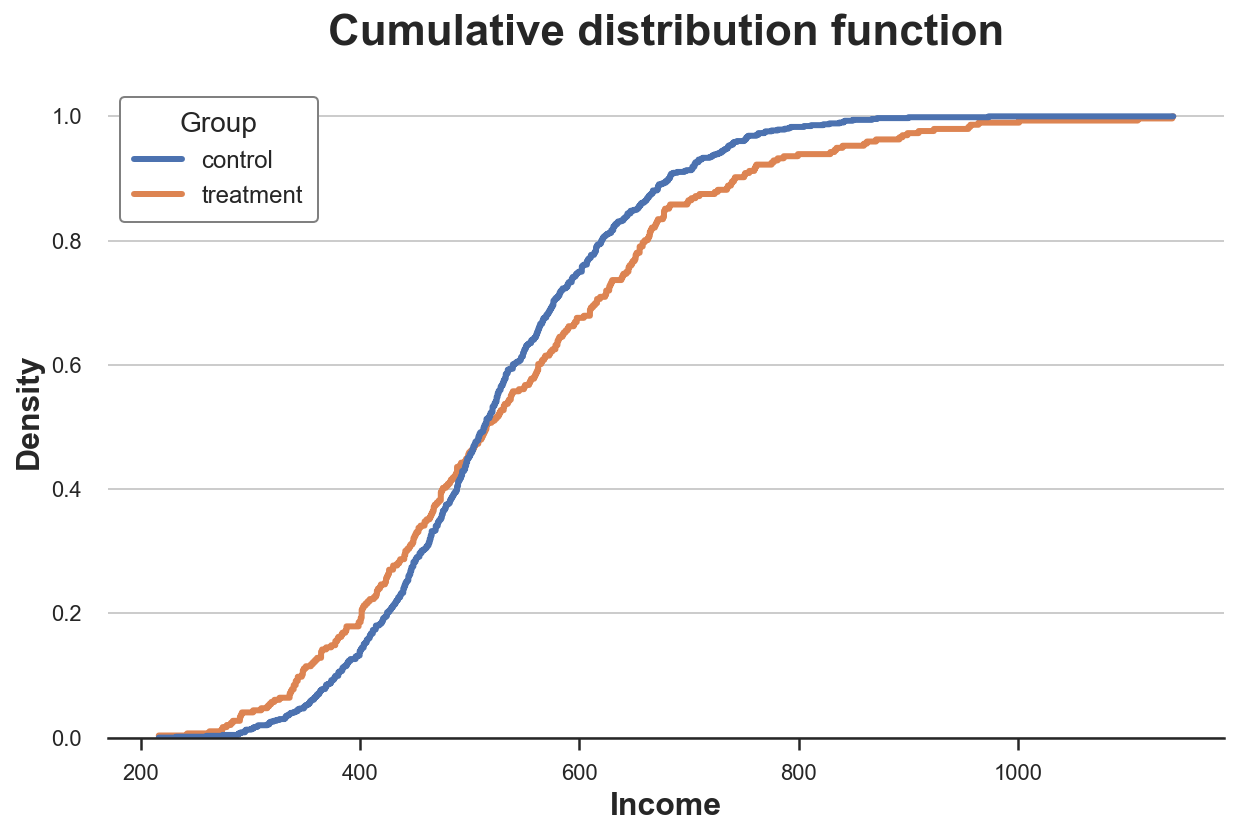

In [7]:
sns.histplot(x='Income', data=df, hue='Group', bins=len(df), stat="density",
             element="step", fill=False, cumulative=True, common_norm=False);
plt.title("Cumulative distribution function");

How should we interpret the graph?

- Since the two lines cross more or less at 0.5 (y axis), it means that their median is similar

- Since the orange line is above the blue line on the left and below the blue line on the left, it means that the distribution of the `treatment` group as fatter tails

### QQ Plot

A related method is the **qq-plot**, where *q* stands for quantile. The qq-plot plots the quantiles of the two distributions against each other. If the distributions are the same, we should get a 45 degree line.

There is no native qq-plot function in Python and, while the `statsmodels` package provides a [`qqplot` function](https://www.statsmodels.org/dev/generated/statsmodels.graphics.gofplots.qqplot.html), it is quite cumbersome. Therefore, we will do it by hand.

First, we need to compute the quartiles of the two groups, using the `percentile` function.

In [8]:
income = df['Income'].values
income_t = df.loc[df.Group=='treatment', 'Income'].values
income_c = df.loc[df.Group=='control', 'Income'].values

df_pct = pd.DataFrame()
df_pct['q_treatment'] = np.percentile(income_t, range(100))
df_pct['q_control'] = np.percentile(income_c, range(100))

Now we can plot the two quantile distributions against each other, plus the 45-degree line, representing the benchmark perfect fit.

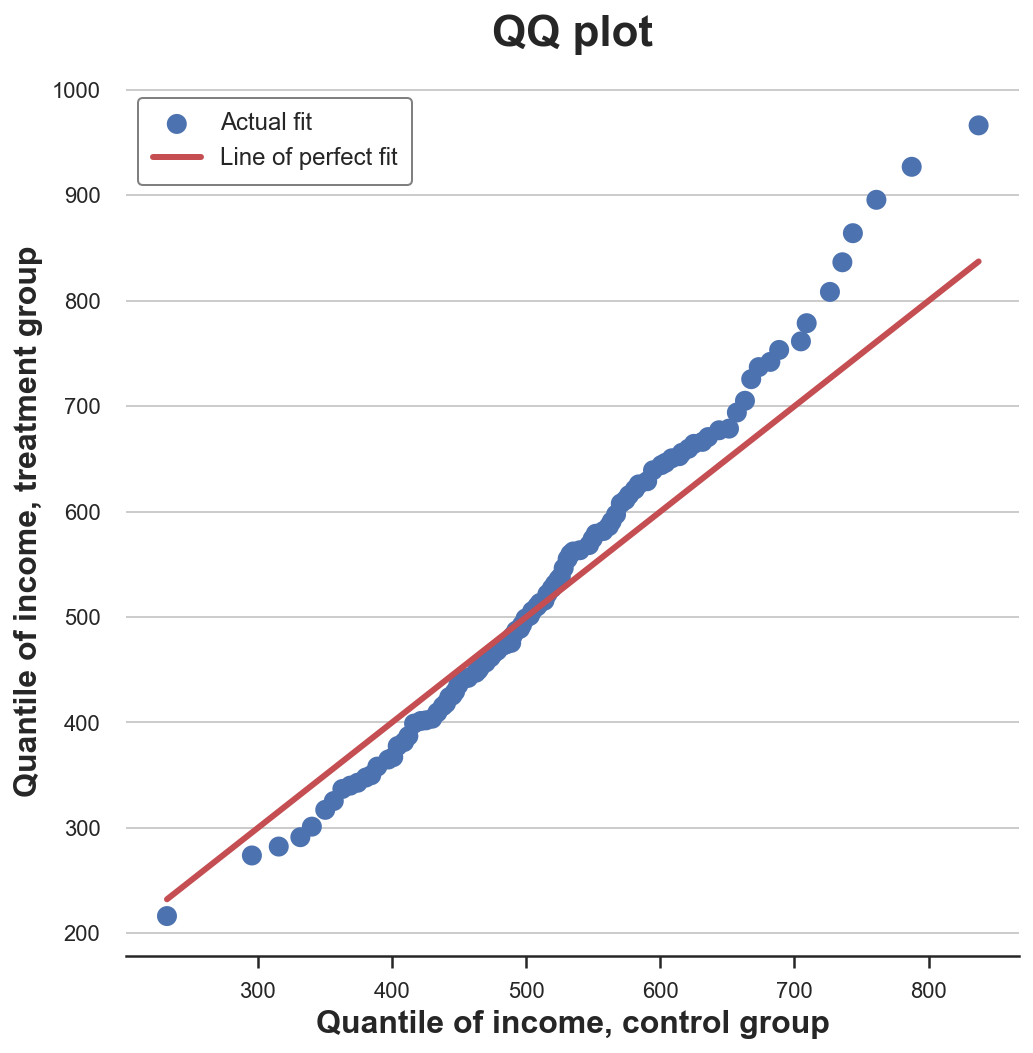

In [9]:
plt.figure(figsize=(8, 8))
plt.scatter(x='q_control', y='q_treatment', data=df_pct, label='Actual fit');
sns.lineplot(x='q_control', y='q_control', data=df_pct, color='r', label='Line of perfect fit');
plt.xlabel('Quantile of income, control group')
plt.ylabel('Quantile of income, treatment group')
plt.legend()
plt.title("QQ plot");

The qq-plot delivers a very **similar insight** with respect to the cumulative distribution plot: income in the treatment group has the same median (lines cross in the center) but wider tails (dots are below the line on the left end and above on the right end).

## Two Groups - Tests

So far, we have seen different ways to *visualize* differences between distributions. The main advantage of visualization is **intuition**: we can eyeball the differences and intuitively assess them.

However, we might want to be more **rigorous** and try to assess the **statistical significance** of the difference between the distributions, i.e. answer the question "*is the observed difference systematic or due to sampling noise?*".

We are now going to analyze different tests to discern two distributions from each other. 

### T-test

The first and most common test is the [student t-test](https://en.wikipedia.org/wiki/Student%27s_t-test). T-tests are generally used to **compare means**. In this case, we want to test whether the means of the `income` distribution is the same across the two groups. The test statistic for the two-means comparison test is given by:

$$
stat = \frac{|\bar x_1 - \bar x_2|}{\sqrt{s^2 / n }}
$$

Where $\bar x$ is the sample mean and $s$ is the sample standard deviation. Under mild conditions, the test statistic is asymptotically distributed as a [student t](https://en.wikipedia.org/wiki/Student%27s_t-distribution) distribution.

We use the `ttest_ind` function from `scipy` to perform the t-test. The function returns both the test statistic and the implied [p-value](https://en.wikipedia.org/wiki/P-value).

In [10]:
from scipy.stats import ttest_ind

stat, p_value = ttest_ind(income_c, income_t)
print(f"t-test: statistic={stat:.4f}, p-value={p_value:.4f}")

t-test: statistic=-1.5549, p-value=0.1203


The p-value of the test is $0.12$, therefore we do **not reject** the null hypothesis of no difference in *means* across treatment and control groups.

> **Note**: the t-test assumes that the variance in the two samples is the same so that its estimate is computed on the joint sample. [Welch’s t-test](https://en.wikipedia.org/wiki/Welch%27s_t-test) allows for unequal variances in the two samples.

### Standardized Mean Difference (SMD)

In general, it is good practice to always perform a test for difference in means on **all variables** across the treatment and control group, when we are running a randomized control trial or A/B test. 

However, since the denominator of the t-test statistic depends on the sample size, the t-test has been **criticized** for making p-values hard to compare across studies. In fact, we may obtain a significant result in an experiment with very small magnitude of difference but large sample size while we may obtain a non-significant result in an experiment with large magnitude of difference but small sample size.

One solution that has been proposed is the **standardized mean difference (SMD)**. As the name suggests, this is not a proper test statistic, but just a standardized difference, which can be computed as:

$$
SMD = \frac{|\bar x_1 - \bar x_2|}{\sqrt{(s^2_1 + s^2_2) / 2}}
$$

Usually a value below $0.1$ is considered a "small" difference. 

It is good practice to collect average values of all variables across treatment and control group and a measure of distance between the two — either the t-test or the SMD — into a table that is called **balance table**. We can use the [`create_table_one`](https://causalml.readthedocs.io/en/latest/causalml.html#module-causalml.match) function from the [`causalml`](https://causalml.readthedocs.io/en/latest/about.html) library to generate it. As the name of the function suggests, the balance table should always be the **first table** you present when performing an A/B test.

In [11]:
from causalml.match import create_table_one

df['treatment'] = df['Group']=='treatment'
create_table_one(df, 'treatment', ['Gender', 'Age', 'Income'])

,Control,Treatment,SMD
Variable,,,
n,704,296,
Age,32.40 (8.54),36.42 (7.76),0.4928
Gender,0.51 (0.50),0.58 (0.49),0.1419
Income,524.59 (117.35),538.75 (160.15),0.1009


In the first two columns, we can see the average of the different variables across the treatment and control groups, with standard errors in parenthesis. In the **last column**, the values of the SMD indicate a standardized difference of more than $0.1$ for all variables, suggesting that the two groups are probably different.

### Mann–Whitney U Test

An alternative test is the [Mann–Whitney U test](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test). The null hypothesis for this test is that the two groups have the same distribution, while the alternative hypothesis is that one group has larger (or smaller) values than the other.

Differently from the other tests we have seen so far, the Mann–Whitney U test is agnostic to outliers and concentrates on the center of the distribution.

The test **procedure** is the following.

1. Combine all data points and rank them (in increasing or decreasing order)

2. Compute $U_1 = R_1 - n_1(n_1 + 1)/2$, where $R_1$ is the sum of the ranks for data points in the first group and $n_1$ is the number of points in the first group.

3. Compute $U_2$ similarly for the second group.

4. The test statistic is given by $stat = min(U_1, U_2)$.

Under the null hypothesis of no systematic rank differences between the two distributions (i.e. same median), the test statistic is asymptotically normally distributed with known mean and variance.

The **intuition** behind the computation of $R$ and $U$ is the following: if the values in the first sample were all bigger than the values in the second sample, then $R_1 = n_1(n_1 + 1)/2$ and, as a consequence, $U_1$ would then be zero (minimum attainable value). Otherwise, if the two samples were similar, $U_1$ and $U_2$ would be very close to $n_1 n_2 / 2$ (maximum attainable value).

We perform the test using the `mannwhitneyu` function from `scipy`.

In [12]:
from scipy.stats import mannwhitneyu

stat, p_value = mannwhitneyu(income_t, income_c)
print(f" Mann–Whitney U Test: statistic={stat:.4f}, p-value={p_value:.4f}")

 Mann–Whitney U Test: statistic=106371.5000, p-value=0.6012


We get a p-value of 0.6 which implies that we do **not reject** the null hypothesis of no difference between the two distributions.

> **Note**: as for the t-test, there exists a version of the Mann–Whitney U test for unequal variances in the two samples, the [Brunner-Munzel test](https://www.statisticshowto.com/brunner-munzel-test-generalized-wilcoxon-test/).

### Permutation Tests

A non-parametric alternative is permutation testing. The idea is that, under the null hypothesis, the two distributions should be the same, therefore **shuffling** the `group` labels should not significantly alter any statistic.

We can chose any statistic and check how its value in the original sample compares with its distribution across `group` label permutations. For example, let's use as a test statistic the **difference of sample means** between the treatment and control group. 

In [13]:
sample_stat = np.mean(income_t) - np.mean(income_c)

In [14]:
stats = np.zeros(1000)
for k in range(1000):
    labels = np.random.permutation((df['Group'] == 'treatment').values)
    stats[k] = np.mean(income[labels]) - np.mean(income[labels==False])
p_value = np.mean(stats > sample_stat)

print(f"Permutation test: p-value={p_value:.4f}")

Permutation test: p-value=0.0530


The permutation test gives us a p-value of $0.056$, implying a weak **non-rejection** of the null hypothesis at the 5% level. 

How do we **interpret** the p-value? It means that the difference in means in the data is larger than $1 - 0.0560 = 94.4\%$ of the differences in means across the permuted samples. 

We can **visualize** the test, by plotting the distribution of the test statistic across permutations against its sample value.

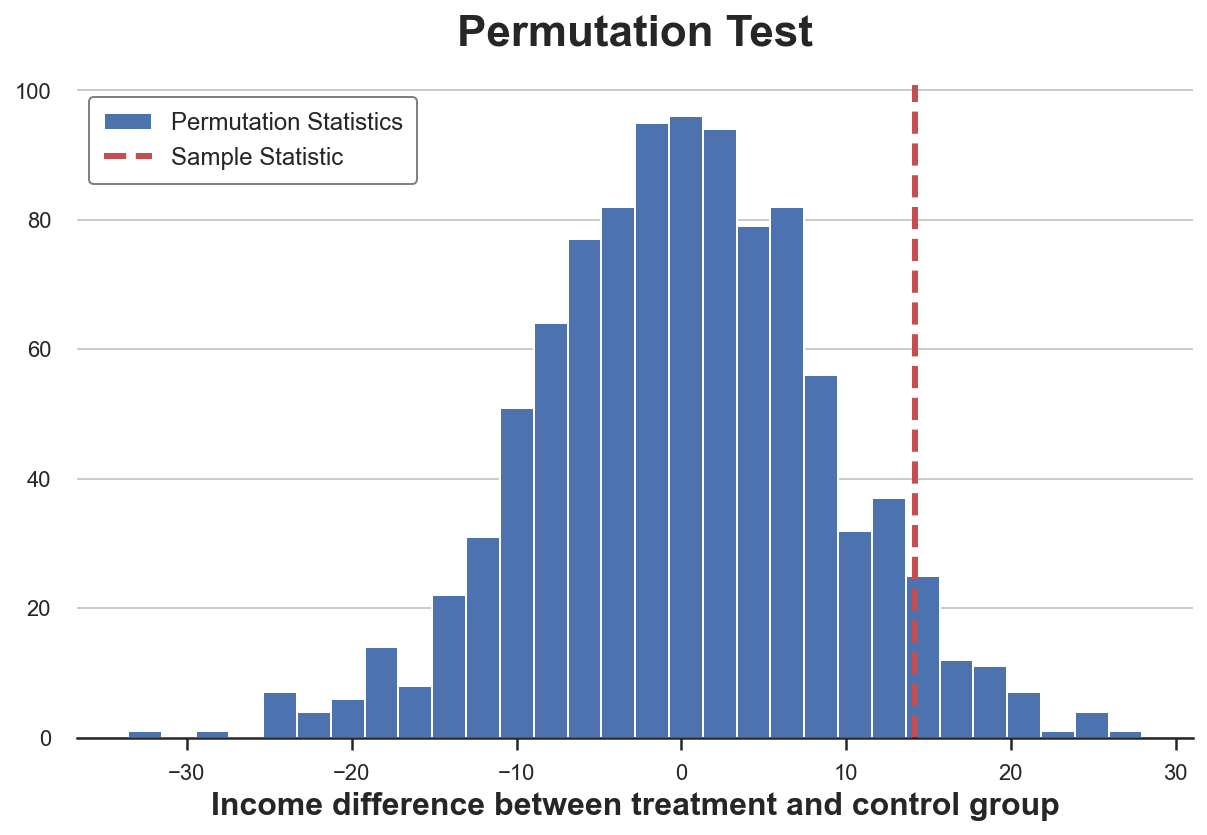

In [15]:
plt.hist(stats, label='Permutation Statistics', bins=30);
plt.axvline(x=sample_stat, c='r', ls='--', label='Sample Statistic');
plt.legend();
plt.xlabel('Income difference between treatment and control group')
plt.title('Permutation Test');

As we can see, the sample statistic is quite extreme with respect to the values in the permuted samples, but not excessively.

### Chi-Squared Test

The [chi-squared test](https://matteocourthoud.github.io/post/chisquared/) is a very powerful test that is mostly used to test differences in frequencies.

One of the **least known applications** of the chi-squared test, is testing the similarity between two distributions. The **idea** is to bin the observations of the two groups. If the two distributions were the same, we would expect the same frequency of observations in each bin. Importantly, we need enough observations in each bin, in order for the test to be valid. 

I generate bins corresponding to deciles of the distribution of `income` in the *control* group and then I compute the expected number of observations in each bin in the *treatment* group, if the two distributions were the same.

In [16]:
# Init dataframe
df_bins = pd.DataFrame()

# Generate bins from control group
_, bins = pd.qcut(income_c, q=10, retbins=True)
df_bins['bin'] = pd.cut(income_c, bins=bins).value_counts().index

# Apply bins to both groups
df_bins['income_c_observed'] = pd.cut(income_c, bins=bins).value_counts().values
df_bins['income_t_observed'] = pd.cut(income_t, bins=bins).value_counts().values

# Compute expected frequency in the treatment group
df_bins['income_t_expected'] = df_bins['income_c_observed'] / np.sum(df_bins['income_c_observed']) * np.sum(df_bins['income_t_observed'])

df_bins

,bin,income_c_observed,income_t_observed,income_t_expected
0,"(232.26, 380.496]",70,46,29.075391
1,"(380.496, 425.324]",70,30,29.075391
2,"(425.324, 456.795]",70,24,29.075391
3,"(456.795, 488.83]",71,26,29.490754
4,"(488.83, 513.66]",70,18,29.075391
5,"(513.66, 540.048]",70,19,29.075391
6,"(540.048, 576.664]",71,21,29.490754
7,"(576.664, 621.022]",70,25,29.075391
8,"(621.022, 682.003]",70,42,29.075391
9,"(682.003, 973.46]",71,41,29.490754


We can now perform the test by comparing the expected (E) and observed (O) number of observations in the treatment group, across bins. The test statistic is given by

$$
stat = \sum _{i=1}^{n} \frac{(O_i - E_i)^{2}}{E_i}
$$

where the bins are indexed by $i$ and $O$ is the observed number of data points in bin $i$ and $E$ is the expected number of data points in bin $i$. Since we generated the bins using deciles of the distribution of `income` in the control group, we expect the number of observations per bin in the treatment group to be the same across bins. The test statistic is asymptocally distributed as a [chi-squared](https://en.wikipedia.org/wiki/Chi-squared_distribution) distribution. 

To compute the test statistic and the p-value of the test, we use the `chisquare` function from `scipy`.

In [17]:
from scipy.stats import chisquare

stat, p_value = chisquare(df_bins['income_t_observed'], df_bins['income_t_expected'])
print(f"Chi-squared Test: statistic={stat:.4f}, p-value={p_value:.4f}")

Chi-squared Test: statistic=32.1432, p-value=0.0002


Differently from all other tests so far, the chi-squared test **strongly rejects** the null hypothesis that the two distributions are the same. Why?

The reason lies in the fact that the two distributions have a similar center but different tails and the chi-squared test tests the similarity along the **whole distribution** and not only in the center, as we were doing with the previous tests.

This result tells a **cautionary tale**: it is very important to understand *what* you are actually testing before drawing blind conclusions from a p-value! 

### Kolmogorov-Smirnov Test

The idea of the [Kolmogorov-Smirnov test](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test), is to **compare the cumulative distributions** of the two groups. In particular, the Kolmogorov-Smirnov test statistic is the maximum absolute difference between the two cumulative distributions.

$$
stat = \sup _{x} \ \Big| \ F_1(x) - F_2(x) \ \Big|
$$

Where $F_1$ and $F_2$ are the two cumulative distribution functions and $x$ are the values of the underlying variable. The asymptotic distribution of the Kolmogorov-Smirnov test statistic is [Kolmogorov distributed](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test#Kolmogorov_distribution).

To better understand the test, let's plot the cumulative distribution functions and the test statistic. First, we compute the cumulative distribution functions.

In [18]:
df_ks = pd.DataFrame()
df_ks['Income'] = np.sort(df['Income'].unique())
df_ks['F_control'] = df_ks['Income'].apply(lambda x: np.mean(income_c<=x))
df_ks['F_treatment'] = df_ks['Income'].apply(lambda x: np.mean(income_t<=x))
df_ks.head()

,Income,F_control,F_treatment
0,216.36,0.000000,0.003378
1,232.26,0.001420,0.003378
2,243.15,0.001420,0.006757
3,259.88,0.002841,0.006757
4,262.82,0.002841,0.010135


We now need to find the point where the absolute distance between the cumulative distribution functions is largest.

In [19]:
k = np.argmax( np.abs(df_ks['F_control'] - df_ks['F_treatment']))
ks_stat = np.abs(df_ks['F_treatment'][k] - df_ks['F_control'][k])

We can visualize the value of the test statistic, by plotting the two cumulative distribution functions and the value of the test statistic.

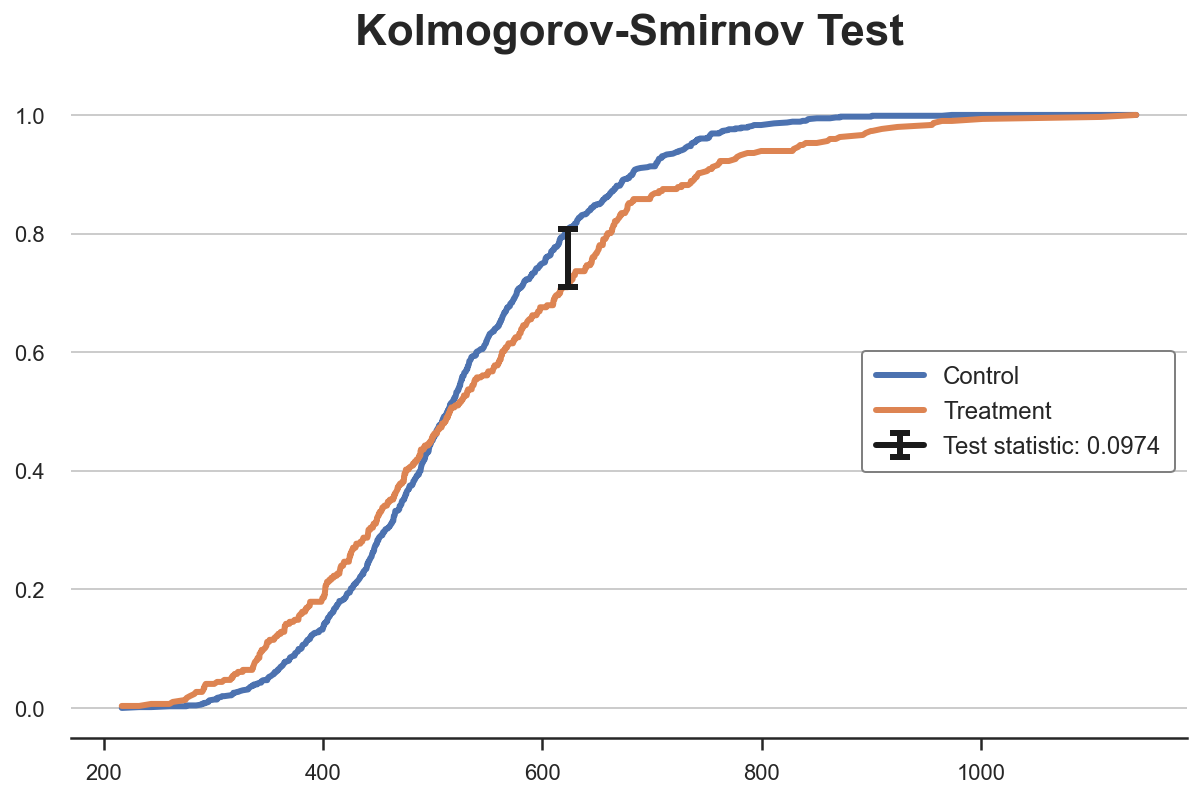

In [20]:
y = (df_ks['F_treatment'][k] + df_ks['F_control'][k])/2
plt.plot('Income', 'F_control', data=df_ks, label='Control')
plt.plot('Income', 'F_treatment', data=df_ks, label='Treatment')
plt.errorbar(x=df_ks['Income'][k], y=y, yerr=ks_stat/2, color='k',
             capsize=5, mew=3, label=f"Test statistic: {ks_stat:.4f}")
plt.legend(loc='center right');
plt.title("Kolmogorov-Smirnov Test");

From the plot, we can see that the value of the test statistic corresponds to the distance between the two cumulative distributions at `income`~650. For that value of `income`, we have the largest imbalance between the two groups.

We can now perform the actual test using the `kstest` function from `scipy`.

In [21]:
from scipy.stats import kstest

stat, p_value = kstest(income_t, income_c)
print(f" Kolmogorov-Smirnov Test: statistic={stat:.4f}, p-value={p_value:.4f}")

 Kolmogorov-Smirnov Test: statistic=0.0974, p-value=0.0355


The p-value is below 5%: we **reject** the null hypothesis that the two distributions are the same, with 95% confidence.

> **Note 1**: The KS test is too conservative and rejects the null hypothesis too rarely. Lilliefors test corrects this bias using a different distribution for the test statistic, the Lilliefors distribution.

> **Note 2**: the KS test uses very little information since it only compares the two cumulative distributions at one point: the one of maximum distance. The [Anderson-Darling test](https://en.wikipedia.org/wiki/Anderson%E2%80%93Darling_test) and the [Cramér-von Mises test](https://en.wikipedia.org/wiki/Cram%C3%A9r%E2%80%93von_Mises_criterion) instead compare the two distributions along the whole domain, by integration (the difference between the two lies in the weighting of the squared distances).

## Multiple Groups - Plots

So far we have only considered the case of two groups: treatment and control. But that if we had **multiple groups**? Some of the methods we have seen above scale well, while others don't.

As a working example, we are now going to check whether the distribution of `income` is the same across treatment `arms`.

### Boxplot

The **boxplot** scales very well, when we have a number of groups in the single-digits, since we can put the different boxes side-by-side. 

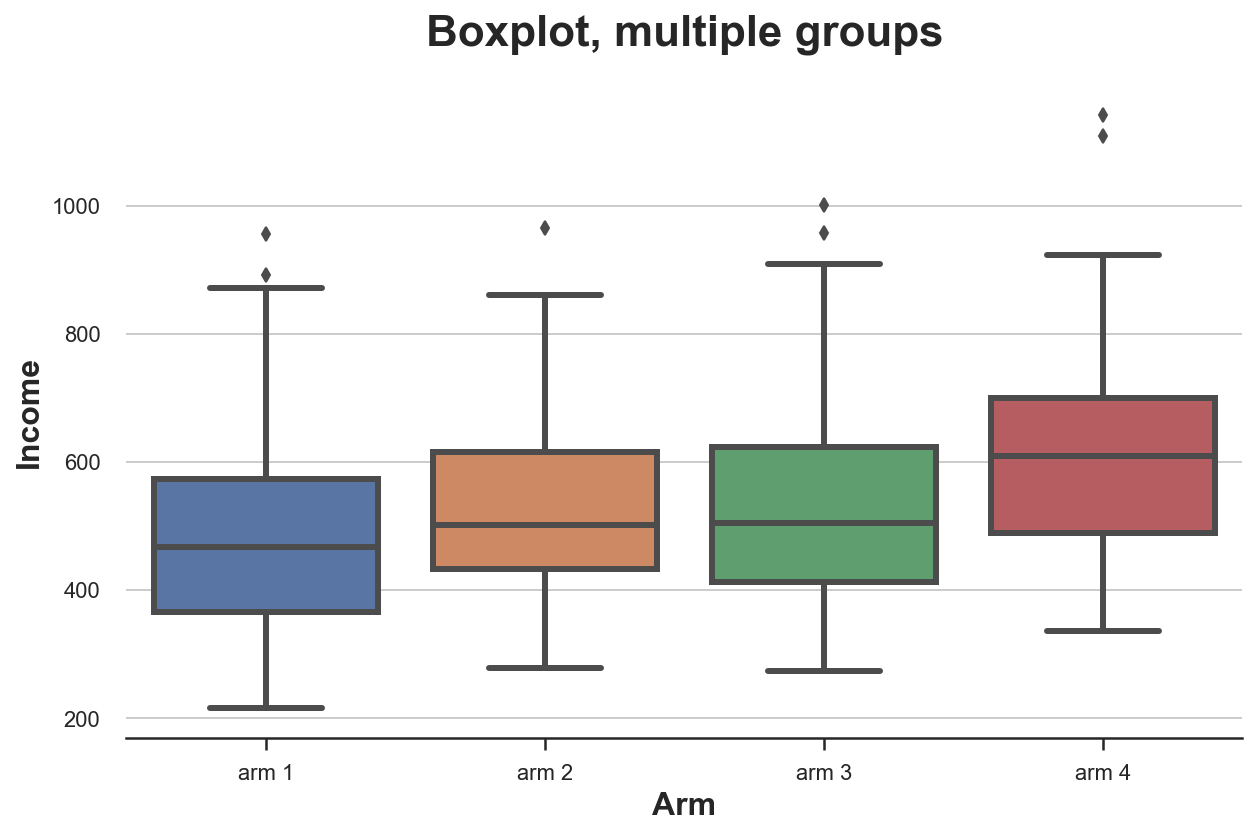

In [22]:
sns.boxplot(x='Arm', y='Income', data=df.sort_values('Arm'));
plt.title("Boxplot, multiple groups");

From the plot, it looks like the distribution of `income` is different across treatment arms, with higher numbered arms having a higher average income.

### Violin Plot

A very nice extension of the boxplot that combines summary statistics and kernel density estimation is the  **violinplot**. The violinplot plots separate densities along the y axis so that they don't overlap. By default, it also adds a miniature boxplot inside. 

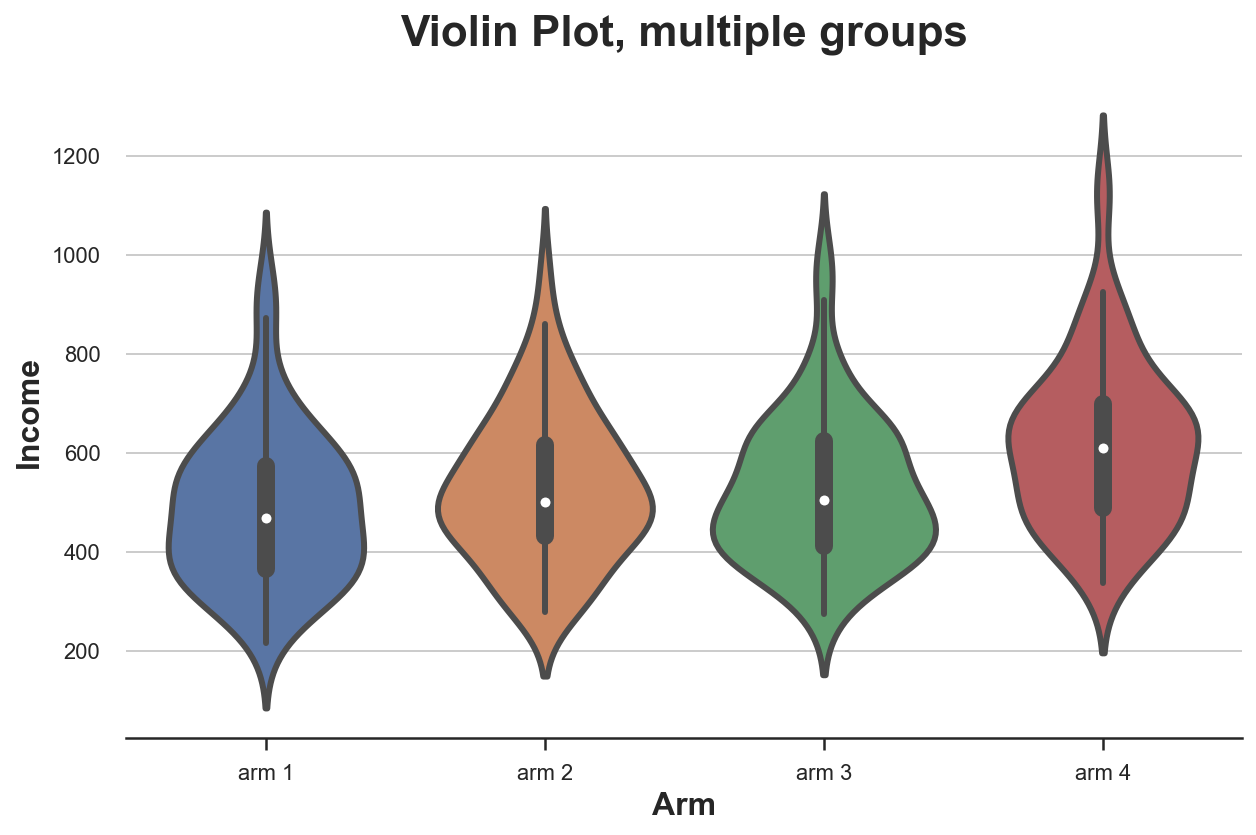

In [23]:
sns.violinplot(x='Arm', y='Income', data=df.sort_values('Arm'));
plt.title("Violin Plot, multiple groups");

As for the boxplot, the violin plot suggests that income is different across treatment arms.

### Ridgeline Plot

Lastly, the **ridgeline plot** plots multiple kernel density distributions along the x-axis, making them more intuitive than the violin plot but partially overlapping them. Unfortunately, there is no default ridgeline plot neither in `matplotlib` nor in `seaborn`. We need to import it from [`joypy`](https://github.com/leotac/joypy).

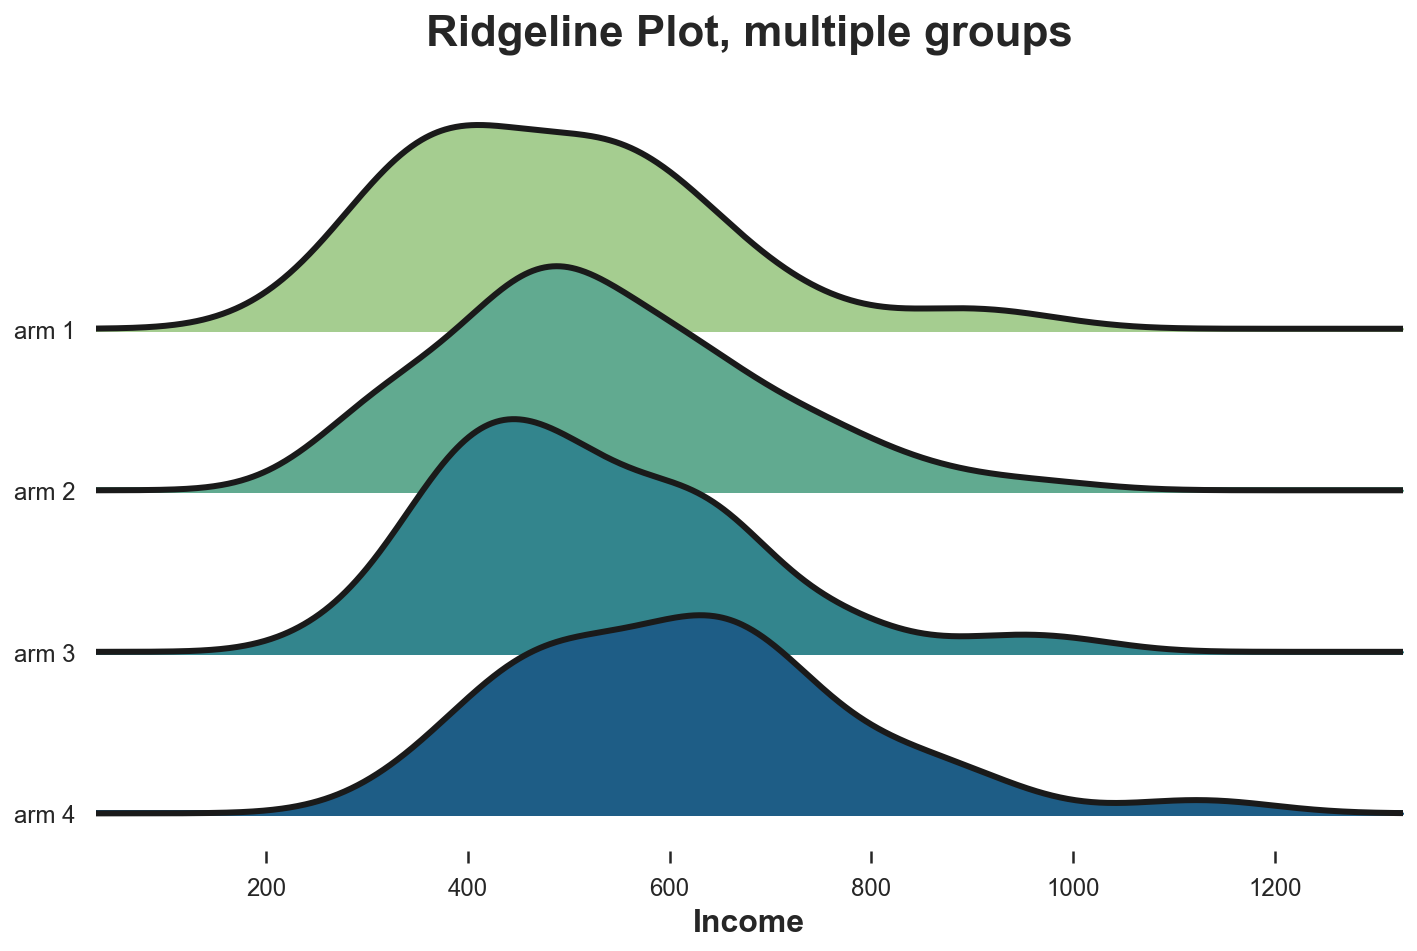

In [24]:
from joypy import joyplot

joyplot(df, by='Arm', column='Income', colormap=sns.color_palette("crest", as_cmap=True));
plt.xlabel('Income');
plt.title("Ridgeline Plot, multiple groups");

Again, the ridgeline plot suggests that higher numbered treatment arms have higher income. From this plot it is also easier to appreciate the different shapes of the distributions.

## Multiple Groups - Tests

Lastly, let's consider hypothesis tests to compare multiple groups. For simplicity, we will concentrate on the most popular one: the F-test.

### F-test

With multiple groups, the most popular test is the [**F-test**](https://en.wikipedia.org/wiki/F-test). The F-test compares the variance of a variable across different groups. This analysis is also called [analysis of variance, or **ANOVA**](https://en.wikipedia.org/wiki/Analysis_of_variance).

In practice, the F-test statistic is

$$
\text{stat} = \frac{\text{between-group variance}}{\text{within-group variance}} = \frac{\sum_{g} \big( \bar x_g - \bar x \big) / (G-1)}{\sum_{g} \sum_{i \in g} \big( \bar x_i - \bar x_g \big) / (N-G)}
$$

Where $G$ is the number of groups, $N$ is the number of observations, $\bar x$ is the overall mean and $\bar x_g$ is the mean within group $g$. Under the null hypothesis of group independence, the f-statistic is [F-distributed](https://en.wikipedia.org/wiki/F-distribution).

In [25]:
from scipy.stats import f_oneway

income_groups = [df.loc[df['Arm']==arm, 'Income'].values for arm in df['Arm'].dropna().unique()]
stat, p_value = f_oneway(*income_groups)
print(f"F Test: statistic={stat:.4f}, p-value={p_value:.4f}")

F Test: statistic=9.0911, p-value=0.0000


The test p-value is basically zero, implying a **strong rejection** of the null hypothesis of no differences in the `income` distribution across treatment arms.

## Conclusion

In this post we have see a ton of different ways to **compare two or more distributions**, both visually and statistically. This is a primary concern in many applications, but especially in causal inference where we use randomization to make treatment and control group as comparable as possible.

We have also seen how different methods might be better suited for **different situations**. Visual methods are great to build intuition, but statistical methods are essential for decision-making, since we need to be able to assess the magnitude and statistical significance of the differences.

### References

[1] Student, [The Probable Error of a Mean](https://www.jstor.org/stable/2331554) (1908), *Biometrika*.

[2] F. Wilcoxon, [Individual Comparisons by Ranking Methods](https://www.jstor.org/stable/3001968) (1945), *Biometrics Bulletin*.

[3] B. L. Welch, [The generalization of "Student's" problem when several different population variances are involved](https://academic.oup.com/biomet/article/34/1-2/28/210174) (1947), *Biometrika*.

[4] H. B. Mann, D. R. Whitney, [On a Test of Whether one of Two Random Variables is Stochastically Larger than the Other](https://www.jstor.org/stable/2236101) (1947), *The Annals of Mathematical Statistics*.

[5] E. Brunner, U. Munzen, [The Nonparametric Behrens-Fisher Problem: Asymptotic Theory and a Small-Sample Approximation](https://onlinelibrary.wiley.com/doi/abs/10.1002/(SICI)1521-4036(200001)42:1%3C17::AID-BIMJ17%3E3.0.CO;2-U) (2000), *Biometrical Journal*.

[6] A. N. Kolmogorov, [Sulla determinazione empirica di una legge di distribuzione](https://link.springer.com/chapter/10.1007/978-94-011-2260-3_15) (1933), *Giorn. Ist. Ital. Attuar.*.

[7] H. Cramér, [On the composition of elementary errors](https://www.tandfonline.com/doi/abs/10.1080/03461238.1928.10416862) (1928), *Scandinavian Actuarial Journal*.

[8] R. von Mises, [Wahrscheinlichkeit statistik und wahrheit](https://www.ams.org/journals/bull/1937-43-05/S0002-9904-1937-06520-7/) (1936), *Bulletin of the American Mathematical Society*.

[9] T. W. Anderson, D. A. Darling, [Asymptotic Theory of Certain "Goodness of Fit" Criteria Based on Stochastic Processes](https://projecteuclid.org/journals/annals-of-mathematical-statistics/volume-23/issue-2/Asymptotic-Theory-of-Certain-Goodness-of-Fit-Criteria-Based-on/10.1214/aoms/1177729437.full) (1953), *The Annals of Mathematical Statistics*.

### Related Articles

- [Goodbye Scatterplot, Welcome Binned Scatterplot](https://towardsdatascience.com/b63dc69e3d8c)

### Code

You can find the original Jupyter Notebook here:

https://github.com/matteocourthoud/Blog-Posts/blob/main/notebooks/distr.ipynb